In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from scipy.stats import linregress
from sklearn.metrics import r2_score

import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point, Polygon
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("RdGy")

import pandas as pd

%load_ext autoreload
%autoreload 2

## Load Natural Earth Low-res Shapefile of Canada

In [2]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

## Define projection and project shapefile into rotated pole coordinates of CanRCM4 model

In [3]:
prj4crs = {'proj': 'ob_tran', 'o_proj':'longlat', 'lon_0':-97, 'o_lat_p':42.5, 'a':1, 'to_meter':0.0174532925199, 'no_defs':True}
canada = can_geom.to_crs(prj4crs)

## Load indices masked to Canada-only (pre-calculated)

In [4]:
with open('/home/nannau/Desktop/shapeindex.pickle', 'rb') as f:
    index_shp_coord = pickle.load(f)

## Load Rainload models and apply mask
---
Load data and interpolate the design value field

In [5]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/storage/home/nannau/mask.nc'
dv = 'Rain-RL50'

interp_dict = get_interpolation(mask_path, PATH, dv)
midx = interp_dict['idx']
midx_shp = np.logical_and(np.array(index_shp_coord), midx)

iens = interp_dict['iens'][:, midx_shp].T

In [6]:
lon, lat = interp_dict['irlat_ens'], interp_dict['irlon_ens']
p = Proj(prj4crs, preserve_units=True)
nlon, nlat = p(lon, lat, inverse=True)
olon, olat = p(nlon, nlat)

# to = {'init':'epsg:4326'}#'+proj=longlat +init=4326'
# fro = prj4crs#'+proj=ob_tran +o_proj=longlat +lon_0=-97 +o_lat_p=42.5 +a=1 +to_meter=0.0174532925199 +no_defs'
    
# coords = to_rotated(interp_dict['irlat_ens'][midx_shp], interp_dict['irlon_ens'][midx_shp], to, fro)
# lat_ens, lon_ens = coords['rlat_obs'], coords['rlon_obs']

# coords['rlon_obs'].min(), coords['rlon_obs'].max(), coords['rlat_obs'].min(), coords['rlat_obs'].max()

nlon = -nlon

# interp_dict['irlat_ens'][midx_shp].max()
# import pyproj


In [12]:
t1, t2 = np.deg2rad(nlat.min()), np.deg2rad(nlat.max())
l2, l1 = np.deg2rad(nlon.min()), np.deg2rad(nlon.max())

# print("l1", l1, "l2", l2, t1, t2)

def loncos(l, l1, l2):
    return np.cos(2*np.pi*(l1-l)/(l1-l2))
    
def latcos(t, t1, t2):
    return np.cos(2*np.pi*(t-t1)/(t2-t1))
    
def f1(x):
    if (l2 <= x) & (x<= (l1+l2)/2.):
        return 0.
    elif ((l1+l2)/2. < x) & (x <= l1):
        return (loncos(x, l1, l2)+1)/2.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g1(x):
    if (t1 <= x) & (x <= (t1+t2)/2.):
        return (latcos(x, t1, t2)+1)/2.
    elif ((t1+t2)/2. < x) & (x <= t2):
        return 0.
    else:
        print(t1, t2, x)
        raise NameError("Did not meet stop criterion.")
        
def f2(x):
    if (l2 <= x) & (x<=l1):
        return (1-loncos(x, l1, l2))/2.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g2(x): 
    if (t1 <=  x) & (x <= t2):
        return (1-latcos(x, t1, t2))/2.
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
def f3(x):
    if (l2 <= x) & (x <= (l1+l2)/2):
        return (loncos(x, l1, l2)+1)/2.
    elif ((l1+l2)/2 < x) & (x <= l1):
        return 0.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g3(x):
    if (t1 <= x) & (x <= (t1+t2)/2):
        return 0.
    elif (((t1+t2)/2) < x) & (x <= t2):
        return (latcos(x, t1, t2)+1)/2 
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
    
def g(m, t):
    if m == 1:
        return g1(t)
    if m == 2:
        return g2(t)
    if m == 3:
        return g3(t)
def f(n, l):
    if n == 1:
        return f1(l)
    if n == 2:
        return f2(l)
    if n == 3:
        return f3(l)
    
hnm = np.ones((3, 3))
def h(t, l):
    for n in np.arange(1, 4):
        for m in np.arange(1, 4):
            hnm[n-1, m-1] = g(m, t)*f(n, l)
    return hnm
          
X = interp_dict['iens'].mean(axis=0)[midx_shp].copy()

In [8]:
# lon, lat = interp_dict['irlon_ens'][midx_shp], interp_dict['irlat_ens'][midx_shp]

In [13]:
coordf = pd.DataFrame({'iens': X, 
                       'irlat_ens': np.deg2rad(nlat[midx_shp]), 
                       'irlon_ens': np.deg2rad(nlon[midx_shp])}
                     )
coordf = coordf[(coordf['irlat_ens'] < t2)&(coordf['irlat_ens'] > t1)&(coordf['irlon_ens'] < l1)&(coordf['irlon_ens'] > l2)]

# d = np.broadcast_to(X, (hnm.shape[0], hnm.shape[1], X.shape[0])).T
# d.setflags(write=1)
d = np.ones((X.shape[0], hnm.shape[0], hnm.shape[1]))
for i, cell in enumerate(coordf['iens']):
    cell = np.broadcast_to(cell, (hnm.shape))
    d[i] = np.multiply(cell, h(coordf['irlat_ens'].values[i], coordf['irlon_ens'].values[i]))
#     print(cell, h(coordf['irlat_ens'].values[i], coordf['irlon_ens'].values[i]), d[i])
#     print()
#     print(np.multiply(cell, h(coordf['irlat_ens'].values[i], coordf['irlon_ens'].values[i])))
#     print()
#     print(d[i])
#     print()
#     print(h(coordf['irlat_ens'].values[i], coordf['irlon_ens'].values[i]))
#     print(cell)


coordf = coordf.apply(np.rad2deg, columns=['irlat_ens', 'irlon_ens'])

In [14]:
# mean = np.broadcast_to(interp_dict['iens'].mean(axis=0)[midx_shp], (d.shape[2], d.shape[1], d.shape[0])).T
# dmn = np.multiply(d, mean)
#  dmn = mean
dmn = d.reshape((d.shape[0], d.shape[1]*d.shape[2]))

In [21]:
# dmn_masked = dmn[midx_shp, ...]
# d.sum(axis=1)
np.allclose(np.sum(dmn, axis=1)/X, 1.0)

True

## Match observation station locations to their nearest interpolated CanRCM grid cell

In [22]:
df = pd.read_csv('/storage/home/nannau/Interim_snow_rain_load_LRstations_delivered_hist.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,2.0,0.763
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.7,0.571
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.4,0.795
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.8,0.371
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.4,0.565


In [23]:
dv = 'RL50 (kPa)'
ndf = match_coords(df, interp_dict, dv, midx_shp)
ndf = ndf[ndf['RL50 (kPa)'] > 0.0]
print("There are ", ndf.shape, "real station observations to fit.")
ndf.head()

There are  (367, 5) real station observations to fit.


,RL50 (kPa),lat,lon,obs_coords,matched_idx
nearest_grid,,,,,
58,0.386,42.2756,-82.9556,"(-4.286848910227873, 10.373390404111557)",58
74,0.465,42.3333,-82.9333,"(-4.227125340313413, 10.379271031382924)",74
413,0.374,42.9922,-82.3047,"(-3.4945859613826147, 10.7134921602455)",413
538,0.564,42.8667,-80.5500,"(-3.3628448895127754, 11.999925006386508)",538
558,0.440,43.0331,-81.1511,"(-3.290371679059054, 11.534368202439223)",558


## Now use the real observations and regress

In [24]:
robs_idx = ndf['matched_idx']
robs = ((ndf[dv].values))
# vT.shape, robs_idx.shape
reofs = dmn[robs_idx, :]

reofs.shape, robs.shape

((367, 9), (367,))

slope 1.0889276715640803 r2_val 0.8550285867810525


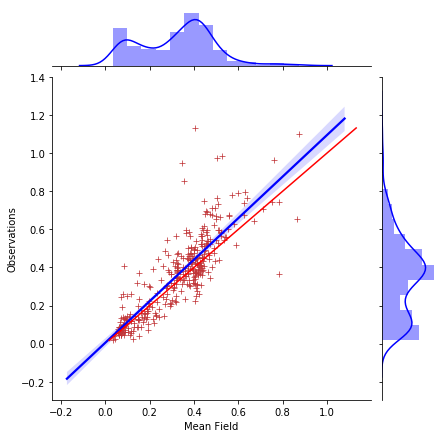

In [25]:
meanfield = iens.mean(axis=1)[robs_idx, ...]
sns.jointplot(meanfield, robs, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(meanfield, robs, marker='+')
sns.lineplot(robs.T, robs.T, color='r', dashes=True)
plt.ylabel('Observations')
plt.xlabel('Mean Field')

slope, intercept, r_value, p_value, std_err = linregress(meanfield, robs)
print("slope", slope, "r2_val", r_value)

Compare the distributions of the station observations and of the models

Fit the model and predict it

In [26]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()

df_results = pd.DataFrame({'Observations': robs, 'Reconstruction': linrpredictions, 'lat': ndf['lat']})
"Regressed model score from EOFs: {}".format(rmodel.score(reofs, robs))

'Regressed model score from EOFs: 0.767700411373809'

In [32]:
rmodel.coef_, rmodel.intercept_

(array([ 0.        , 15.61838881, 52.42932817,  1.45625522,  0.63566882,
         1.14373657, 12.37405099, -2.05103963,  1.94119614]),
 0.05228124435787751)

slope of best fit 0.7677004113738098
r2 score of EOF fit 0.767700411373809
r2_val of reconstruction score 0.8761851467434323
Std deviation ratio of vectors [models/]: 0.0738042861676272


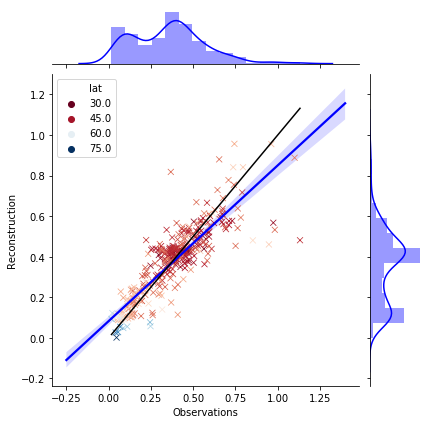

In [30]:
sns.jointplot('Observations', 'Reconstruction', color='blue',
marker='+', data=df_results,
kind="reg", scatter_kws={"s": 0.001})

sns.lineplot('Observations', 'Observations', data=df_results, color='black')
sns.scatterplot('Observations', 'Reconstruction', marker='x', hue='lat', palette='RdBu', data=df_results)
slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope of best fit", slope)
print("r2 score of EOF fit", rmodel.score(reofs, robs))
print("r2_val of reconstruction score", r_value)
print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

## Now reconstruct the spatial field

## Add noise to the ideal pseudo observations, regress, and reconstruct and compare each step with anomaly

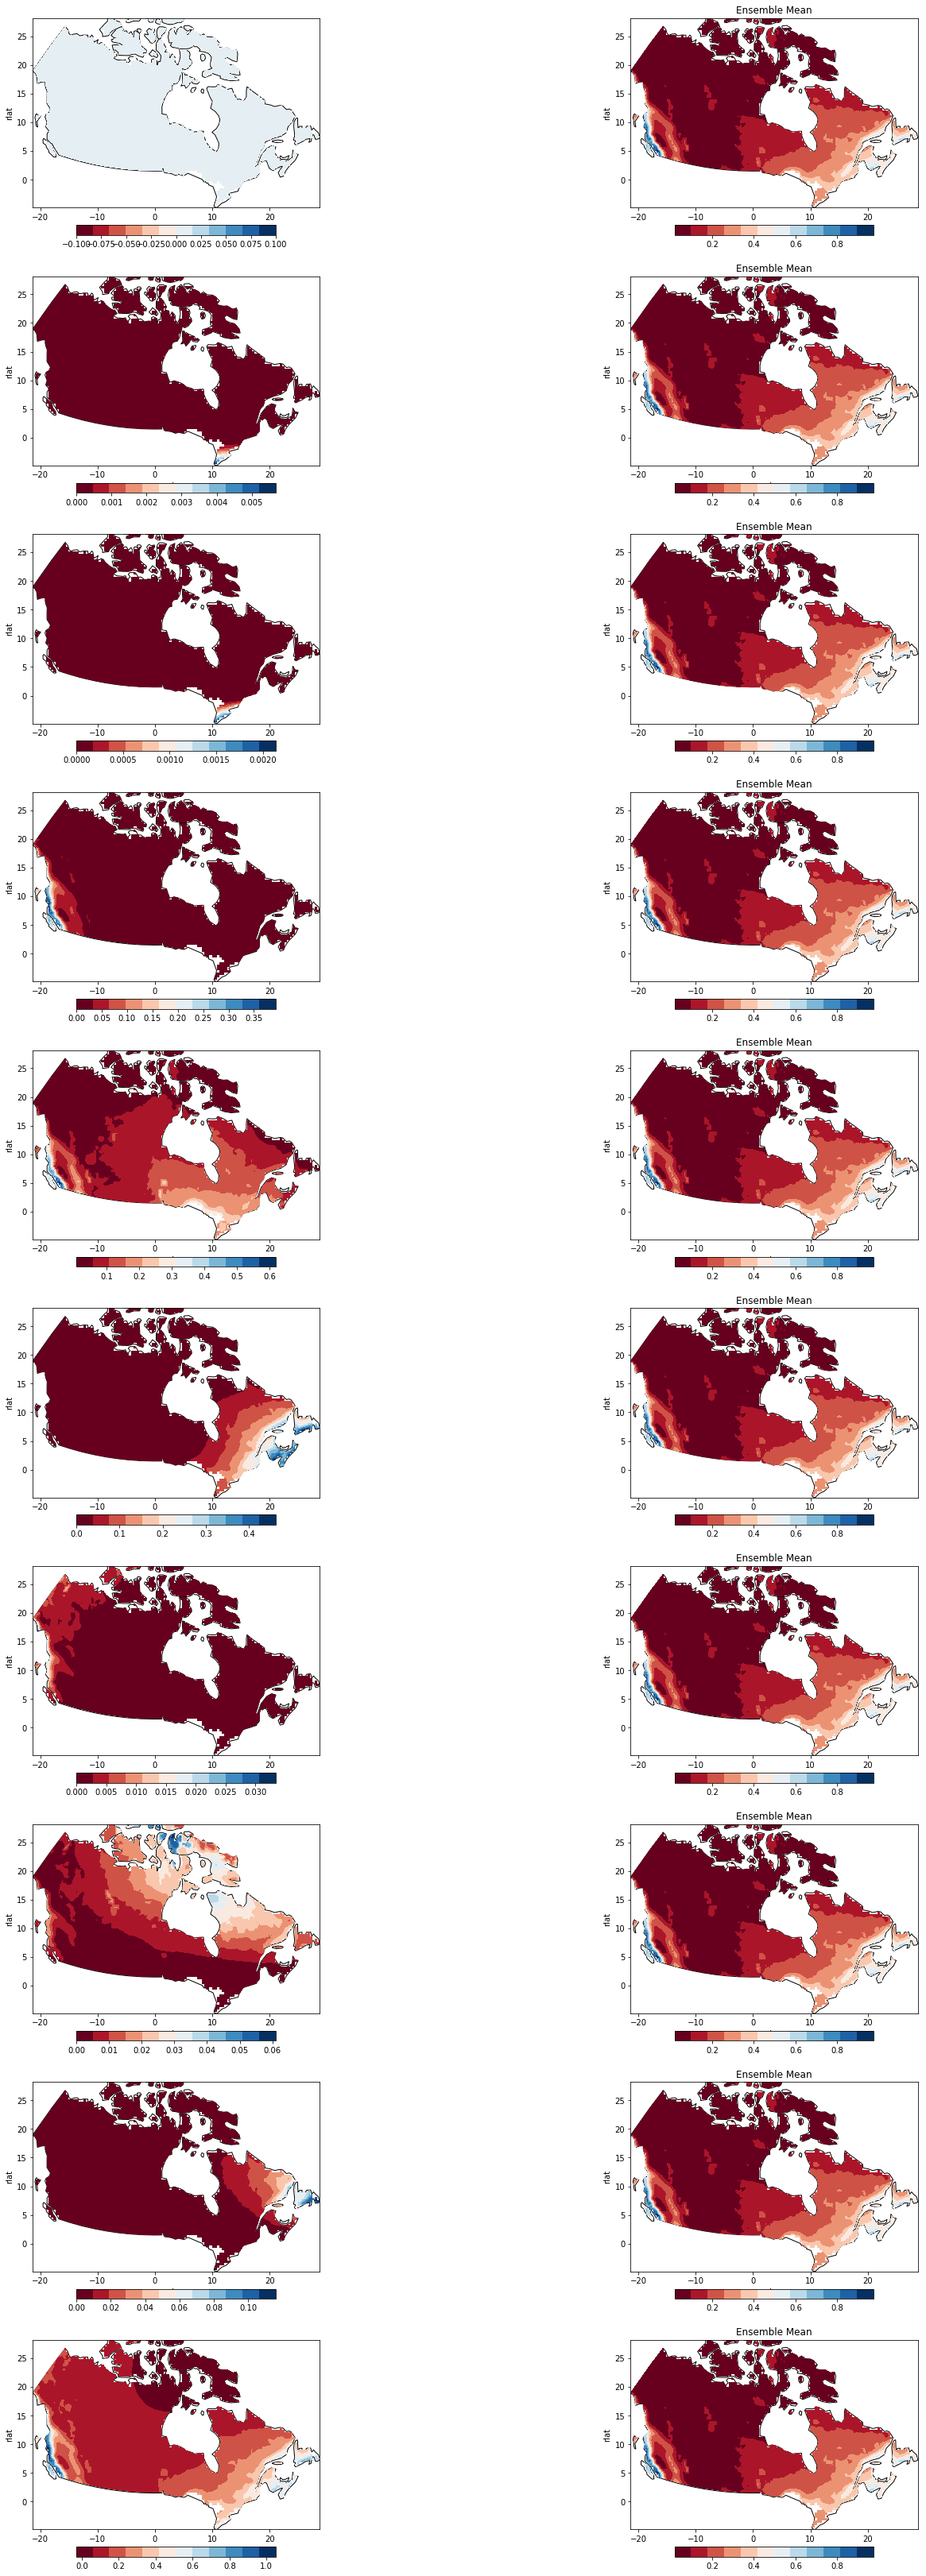

In [31]:
# del iens_copy, X, predictions, y, X_v
iens_copy = np.full_like(np.zeros(interp_dict['iens'].shape), np.nan)
X_v = interp_dict['iens']
X_v[:, ~midx_shp] = np.nan 
# vmin, vmax = 0.0, 0.01

fig, ax = plt.subplots(10, 2, figsize=(30,45))
for i, d in enumerate(dmn[1]):
    dv_recon = interp_dict['iens'][0, :].copy()
    dv_recon[midx_shp] = dmn[:, i]#rmodel.predict(vT[:n, :].T)
    dv_recon[~midx_shp] = np.nan

    X = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])
    x1, x2, y1, y2 = interp_dict['irlon_ens'].min(), interp_dict['irlon_ens'].max(), interp_dict['irlat_ens'].min(), interp_dict['irlat_ens'].max()
    X_v = np.reshape(X_v, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))
    xc, yc = interp_dict['irlon'], interp_dict['irlat']
    
    ax[i, 0].set_xlabel('rlon')
    ax[i, 0].set_ylabel('rlat')
    ax[i, 0].set_ylim(canada.bounds.miny.values[0], y2)
    ax[i, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    canada.plot(ax=ax[i, 0], color='white', edgecolor='black', zorder=1)

    img = ax[i, 0].imshow(X, origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', zorder=2,extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[i, 0], fraction=0.046, pad=0.08)

    ax[i, 1].set_title('Ensemble Mean')
    ax[i, 1].set_xlabel('rlon')
    ax[i, 1].set_ylabel('rlat')
    ax[i, 1].set_ylim(canada.bounds.miny.values[0], y2)
    ax[i, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    
    canada.plot(ax=ax[i, 1], color='white', edgecolor='black', zorder=1)

    img = ax[i, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', zorder=2, extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[i, 1], fraction=0.046, pad=0.08)

    
dv_recon[midx_shp] = rmodel.predict(dmn)
dv_recon[~midx_shp] = np.nan

pred = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

    
ax[9, 0].set_xlabel('rlon')
ax[9, 0].set_ylabel('rlat')
ax[9, 0].set_ylim(canada.bounds.miny.values[0], y2)
ax[9, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
canada.plot(ax=ax[9, 0], color='white', edgecolor='black', zorder=1)

img = ax[9, 0].imshow(pred, origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', zorder=2,extent=[x1, x2, y1, y2])
plt.colorbar(img, orientation='horizontal', ax=ax[9, 0], fraction=0.046, pad=0.08)

ax[9, 1].set_title('Ensemble Mean')
ax[9, 1].set_xlabel('rlon')
ax[9, 1].set_ylabel('rlat')
ax[9, 1].set_ylim(canada.bounds.miny.values[0], y2)
ax[9, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])

canada.plot(ax=ax[9, 1], color='white', edgecolor='black', zorder=1)

img = ax[9, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', zorder=2, extent=[x1, x2, y1, y2])
plt.colorbar(img, orientation='horizontal', ax=ax[9, 1], fraction=0.046, pad=0.08)

    
plt.tight_layout(pad=0.6, h_pad=1.9, w_pad=0.1)
plt.savefig('recon_mean_comparison_spatial.pdf')